# Designing GLM with additional confounds for MCA Subject Level Stat Analysis

Importing all the necessary OS, shell scripting and imaging operations:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import seaborn as sns
import pandas as pd
import os
from os.path import join, dirname, abspath, isfile, isdir, split, splitext, exists, basename
import sys
import subprocess
import re
import glob
import argparse
import shutil
import json
import nibabel as nib
from nilearn import plotting
from nilearn.image import load_img, mean_img, new_img_like, resample_to_img, threshold_img, high_variance_confounds
from nilearn import datasets
from nilearn import maskers
from nilearn import signal
from nipype.interfaces.fsl.utils import ImageMeants
from nilearn.glm.first_level import FirstLevelModel
from nilearn.interfaces.fsl import get_design_from_fslmat
from statsmodels.stats.outliers_influence import variance_inflation_factor
from nilearn.plotting import plot_stat_map, plot_glass_brain, plot_epi, plot_contrast_matrix
from nilearn.plotting import plot_design_matrix, plot_anat, plot_img, plot_roi


In [53]:
%env

{'ANTSPATH': '/Users/vogtlab/ants/bin',
 'COMMAND_MODE': 'unix2003',
 'DISPLAY': '/private/tmp/com.apple.launchd.yMFDVx09Gh/org.xquartz:0',
 'FSLDIR': '/Users/vogtlab/fsl',
 'FSLGECUDAQ': 'cuda.q',
 'FSLMULTIFILEQUIT': 'TRUE',
 'FSLOUTPUTTYPE': 'NIFTI_GZ',
 'FSLTCLSH': '/Users/vogtlab/fsl/bin/fsltclsh',
 'FSLWISH': '/Users/vogtlab/fsl/bin/fslwish',
 'FSL_LOAD_NIFTI_EXTENSIONS': '0',
 'FSL_SKIP_GLOBAL': '0',
 'HDF5PATH': '/Users/vogtlab/hdf5/Contents/bin',
 'HOME': '/Users/vogtlab',
 'LOGNAME': 'vogtlab',
 'MATLABPATH': '/Applications/MATLAB_R2021b.app/bin',
 'MallocNanoZone': '0',
 'ORIGINAL_XDG_CURRENT_DESKTOP': 'undefined',
 'PATH': '/usr/local/bin:/Users/vogtlab/Library/Python/3.11/bin:/Applications/MATLAB/spm12/bin:/Applications/MATLAB_R2021b.app/bin::/Users/vogtlab/c3d/Contents/bin:/Users/vogtlab/ants/bin:/usr/local/lib/python3.11/site-packages:/Users/vogtlab/fsl/share/fsl/bin:/Users/vogtlab/fsl/share/fsl/bin:/Users/vogtlab/c3d/Contents/bin:/Users/vogtlab/ants/bin:/usr/local/lib/p

## Preparing the WM, CSF CompCor Eigenseries from FSL FEAT results for a consolidated GLM matrix with new confounds

TO BE EDITED AFTER ALL RUNS:
 File path and directories used:

funcpath = '/Users/vogtlab/Documents/NeuCLA/FSL/func/' containing all filtered functional data 

eigen_series = 'Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/NLA*/Pain_func*/NLA*_Pre_010*.feat/NLA*_Pre_010*_filtered_func_data_reg_eigen_series_n10_WMCSF_ICBM_MNI.tsv' containing the .txt files that have all regressor columns as EVs from WM and CSF : #5_CompCor_WM and #5_CompCor_CSF columns and ............filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv for the combined #5_CompCor components





In [2]:
# path = '/Users/vogtlab/Documents/NeuCLA/FSL/'
# funcpath = '/Users/vogtlab/Documents/NeuCLA/FSL/func/'
MNIpath = os.environ['FSLDIR']
MNI_file = MNIpath + '/data/standard/MNI152_T1_2mm_brain.nii.gz'
MCA_path = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/'
MCA_datapath = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/MCA*/Mem*_func/MCA*_corrected.nii.gz'
MCA_featpath = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat'

In [3]:
MNI_file

'/Users/suja/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'

In [3]:
# list all the newest feat folders created in this month in the path /Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/

feat_folders = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat')
feat_folders.sort()


In [4]:
feat_folders 

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m1_Pre_04022024_142116.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m2_Pre_04022024_142854.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_

## In case of subject-specific anatomical masks

In [8]:
# copy all the files called highres.nii.gz in the feat folders to the path /Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/ into corresponding filenames
for feat_folder in feat_folders:
    # find the MNI registered T1 file called highres.nii.gz in the feat folder
    reg_T1 = glob.glob(feat_folder + reg_standard/reg/highres.nii.gz')
    # copy the file highres.nii.gz to the path /Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/ into corresponding filenames
    shutil.copy(reg_T1[0], Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/' + os.path.basename(feat_folder) + '.nii.gz')

# list all the files called highres.nii.gz in the path /Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/   
anat_files = glob.glob(Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA*_Pre_010*.nii.gz')
anat_files.sort()
anat_files

['/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA02_Pain1_Pre_01082024_192248.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA02_Pain2_Pre_01082024_192248.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA03_Pain1_Pre_01082024_232205.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA03_Pain2_Pre_01082024_232205.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA04_Pain1_Pre_01082024_232205.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA04_Pain2_Pre_01082024_232205.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA05_Pain1_Pre_01082024_232205.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA05_Pain2_Pre_01082024_232205.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA07_Pain1_Pre_01082024_232205.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA07_Pain2_Pre_01082024_2

In [12]:
# replace the extension of the files called highres.nii.gz in the path /Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/ with .nii.gz
for anat_file in anat_files:
    os.rename(anat_file, anat_file.replace('.feat.nii.gz', '_highres_reg.nii.gz'))

# list all the files called highres.nii.gz in the path /Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat
anat_files = glob.glob(Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA*_Pre_010*.nii.gz')
anat_files.sort()
anat_files


['/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA02_Pain1_Pre_01082024_192248_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA02_Pain2_Pre_01082024_192248_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA03_Pain1_Pre_01082024_232205_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA03_Pain2_Pre_01082024_232205_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA04_Pain1_Pre_01082024_232205_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA04_Pain2_Pre_01082024_232205_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA05_Pain1_Pre_01082024_232205_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA05_Pain2_Pre_01082024_232205_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA07_Pain1_Pre_01082024_232205_highres_reg.nii.gz',
 '/Volumes/cerebro/

In [ ]:
# copy all the files called examplefunc2standard.mat transformation matrices in the feat folders
for feat_folder in feat_folders:
    # find the .mat file in the feat folder
    reg_mat = glob.glob(feat_folder + 'reg/example_func2standard.mat')
    # copy the file into corresponding filenames by removing the extension .feat
    shutil.copy(reg_mat[0], os.path.abspath(feat_folder) + os.path.basename(feat_folder).replace('.feat', '.mat'))
    

## Get all the needed registration matrices and filtered functional data from MCA Preprocessed Data

In [6]:
# list all the .mat files 
mat_files = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat/reg/example_func2standard.mat')
mat_files.sort()
mat_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m1_Pre_04022024_142116.feat/reg/exam

In [6]:
# list all func files
func_files = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat/filtered_func_data.nii.gz')
func_files.sort()
func_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m1_Pre_04022024_142116.feat/filtered_func_data.nii.gz',
 '/V

## Trial Dataset

In [61]:
mat_files_trial = mat_files[2:4]
mat_files_trial

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/reg/example_func2standard.mat']

In [62]:
func_files_trial = func_files[2:4]
func_files_trial


['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/filtered_func_data.nii.gz']

In [19]:
MNI_file

'/Users/vogtlab/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'

In [63]:
# use FSL registration tool for registering the functional images to the MNI space using the .mat transformation matrices
for i in range(len(mat_files_trial)):
    # register the functional images in func_file_trial to the MNI space using the .mat transformation matrices in mat_files_trial
    # print statemennt saying which file is being registered
    print('Registering ' + func_files_trial[i] + ' to MNI space using ' + mat_files_trial[i])
    subprocess.run(['flirt', '-in', func_files_trial[i], '-ref', MNI_file, '-applyxfm', '-init', mat_files_trial[i], '-out', func_files_trial[i].replace('.nii.gz', '_reg.nii.gz')])

Registering /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/filtered_func_data.nii.gz to MNI space using /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/reg/example_func2standard.mat
Registering /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/filtered_func_data.nii.gz to MNI space using /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/reg/example_func2standard.mat


## Registration of the filtered func data in each of the feat folders from previously computed transformation matrices

In [8]:
# use FSL registration tool for registering the functional images to the MNI space using the .mat transformation matrices
# for i in range(len(feat_folders)):
for i in range(0, 287): # loop through 287 MEM feat_folders
    # print the file being processed
    print(os.path.basename(feat_folders[i]))

    if exists(func_files[i].replace('.nii.gz', '_reg.nii.gz')):
        print(os.path.basename(feat_folders[i])+ ' registered.')
        continue
    else:
        # register the functional images  to the MNI space using the .mat transformation matrices in reg_mat_files   
        subprocess.run(['flirt', '-in', func_files[i], '-ref', MNI_file, '-applyxfm', '-init', mat_files[i], '-out', func_files[i].replace('.nii.gz', '_reg.nii.gz')])
        # print statemennt saying which file is being registered
        print('Registered ' + func_files[i] + ' to MNI space using ' + mat_files[i])

10-1-m1_Pre_012723_102400.feat
10-1-m1_Pre_012723_102400.feat registered.
10-1-m2_Pre_012823_102400.feat
10-1-m2_Pre_012823_102400.feat registered.
10-2-m1_Pre_032223_102400.feat
10-2-m1_Pre_032223_102400.feat registered.
10-2-m2_Pre_032223_102400.feat
10-2-m2_Pre_032223_102400.feat registered.
100-1-m1_Pre_04022024_104429.feat
100-1-m1_Pre_04022024_104429.feat registered.
100-1-m2_Pre_04022024_104429.feat
100-1-m2_Pre_04022024_104429.feat registered.
100-2-m1_Pre_04022024_142116.feat
100-2-m1_Pre_04022024_142116.feat registered.
100-2-m2_Pre_04022024_142854.feat
100-2-m2_Pre_04022024_142854.feat registered.
103-1-m1_Pre_11092023_150057.feat
103-1-m1_Pre_11092023_150057.feat registered.
103-1-m2_Pre_11092023_150057.feat
103-1-m2_Pre_11092023_150057.feat registered.
103-2-m1_Pre_11092023_150057.feat
103-2-m1_Pre_11092023_150057.feat registered.
103-2-m2_Pre_11092023_150057.feat
103-2-m2_Pre_11092023_150057.feat registered.
104-1-m1_Pre_03122024_175436.feat
104-1-m1_Pre_03122024_175436.f

In [4]:
# list all the registered functional images in the feat folders
reg_func_files = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat/filtered_func_data_reg.nii.gz')
reg_func_files.sort()
reg_func_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m1_Pre_04022024_142116.feat/filtered

In [11]:
len(reg_func_files) 

287

In [12]:
# check if the legth of the files in reg_mat_files and func_files are the same as the length of the feat_folders
len(mat_files) == len(func_files) == len(feat_folders) == len(reg_func_files)

True

Compute the mean of the registered functional files for underlay

In [13]:
# compute the mean of all the files in reg_func_files
mean_reg_func = mean_img(reg_func_files)
mean_reg_func

In [11]:
# save the mean image as mean_reg_func.nii.gz 
mean_reg_func_file = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/mean_reg_func_mem.nii.gz'
# mean_reg_func.to_filename(mean_reg_func_file)


## CompCor Computation

Resampling of the masks are done below. The WM and CSF masks are accessed from the ICBM MNI WM and CSF templates from nilearn repository and resampled to the mean reg functional file from MCA dataset to apply them for 5 CompCor components

In [8]:
# Define the filenames for original and resampled mask file paths for WM and CSF
# mask_file_WM = Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/MNI_WMmask.nii.gz'
mask_file_WM = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/templates/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_wm_tal_nlin_sym_09a.nii.gz'
resampled_mask_file_WM = mask_file_WM.replace('.nii.gz', '_resampled_to_meanfunc_75.nii.gz') # 0.5 thresholding vs 0.99 thresholding vs 0.75 thresholding

# mask_file_CSF = Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/MNI_CSFmask.nii.gz'
mask_file_CSF = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/templates/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_csf_tal_nlin_sym_09a.nii.gz'
resampled_mask_file_CSF = mask_file_CSF.replace('.nii.gz', '_resampled_to_meanfunc_75.nii.gz')

In [9]:
print(resampled_mask_file_CSF)
print(resampled_mask_file_WM)
# print(mean_reg_func_file)

/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/templates/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_csf_tal_nlin_sym_09a_resampled_to_meanfunc_75.nii.gz
/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/templates/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_wm_tal_nlin_sym_09a_resampled_to_meanfunc_75.nii.gz


In [13]:
# defining the filename combine the resampled mask images for WM and CSF
combined_mask_file = resampled_mask_file_WM.replace('wm', 'WM+CSF')  
combined_mask_file

'/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/templates/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_WM+CSF_tal_nlin_sym_09a_resampled_to_meanfunc_75.nii.gz'

In [14]:
# load data
img_wm_mask = load_img(mask_file_WM)
img_csf_mask = load_img(mask_file_CSF)

# image operation to combine the resampled mask images for WM and CSF
img_combined_mask = new_img_like(img_wm_mask, img_wm_mask.get_fdata() + img_csf_mask.get_fdata())

# resample the mask to match mean file's resolution/dimensions
img_combined_mask = resample_to_img(img_combined_mask, mean_reg_func_file, interpolation = 'nearest')

# binarise the combined mask image
img_combined_mask = threshold_img(img_combined_mask, threshold=0.5)
img_combined_mask.to_filename(combined_mask_file)


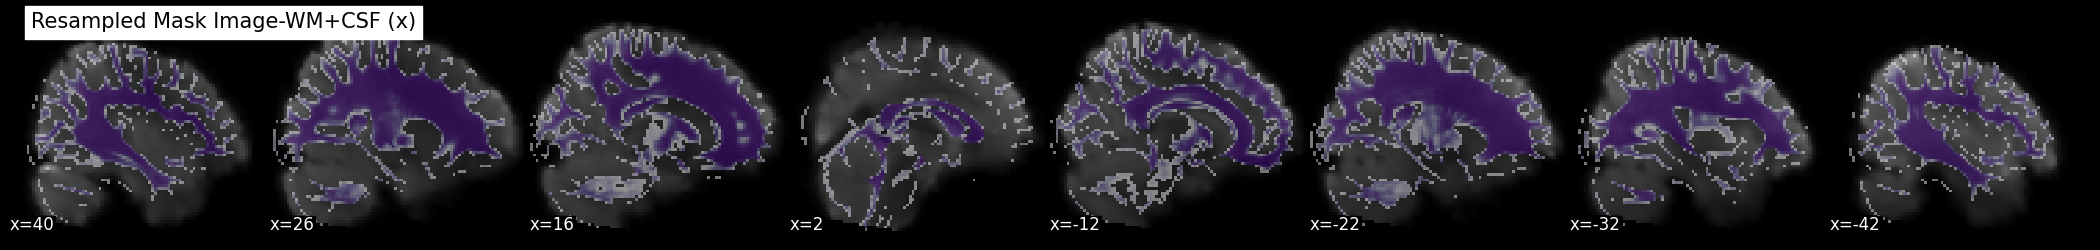

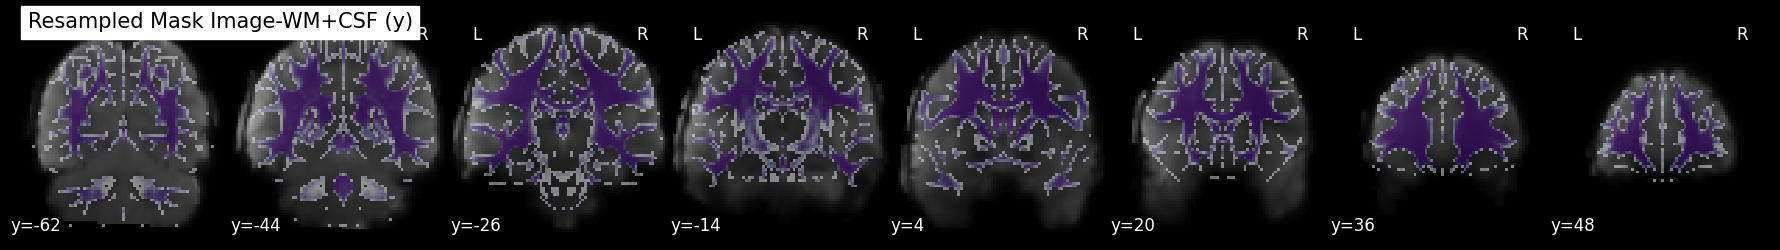

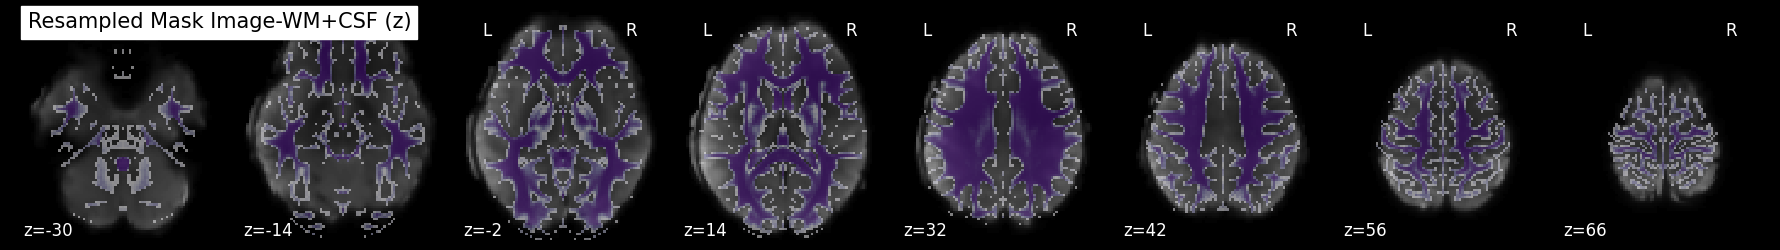

In [15]:
# Computing the WM and CSF masks for trial data from MCA dataset

# Load the example func .nii.gz file for resampling the mask image
in_file =  reg_func_files[0]
img = load_img(in_file)


# plot the resampled mask image on the in_file mean image using nilearn plotting
mean_reg_sub_file = mean_img(in_file)

# Create a montage of slices in x, y and z directions
for display_mode in ['x', 'y', 'z']:
    # plotting.plot_roi(resampled_mask_file_WM, mean_reg_sub_file, title=f"Resampled Mask Image-WM ({display_mode})", display_mode=display_mode, cut_coords=8, colorbar=False, cmap='Reds', linewidths=5, alpha=0.5)
    # #savefig(f"Resampled Mask Image-WM ({display_mode}).png")
    # plotting.plot_roi(resampled_mask_file_CSF, mean_reg_sub_file, title=f"Resampled Mask Image-CSF ({display_mode})", display_mode=display_mode, cut_coords=8, colorbar=False, cmap='Blues', linewidths=5, alpha=0.5)
    #savefig(f"Resampled Mask Image-CSF ({display_mode}).png")
    plotting.plot_roi(combined_mask_file, mean_reg_sub_file, title=f"Resampled Mask Image-WM+CSF ({display_mode})", display_mode=display_mode, cut_coords=8, colorbar=False, cmap='Purples', linewidths=5, alpha=0.5)

plotting.show()


In [ ]:
func_underlay = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/mean_reg_func_trial.nii.gz'
combined_mask_file = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/templates/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_WM+CSF_tal_nlin_sym_09a_resampled_to_meanfunc.nii.gz'
#plotting "Resampled Mask Image-WM+CSF" on the mean_reg_func image
plotting.plot_roi(combined_mask_file, func_underlay, title=None, display_mode='ortho', colorbar=False, cmap='coolwarm', linewidths=5, alpha=0.5, draw_cross=False, annotate=False, black_bg=True, axes=None)

Function Defined for the CompCor Using FSL ImageMeanTS

In [28]:
reg_func_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m1_Pre_04022024_142116.feat/filtered

In [29]:
combined_mask_file

'/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/templates/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_WM+CSF_tal_nlin_sym_09a_resampled_to_meanfunc_75.nii.gz'

In [16]:
# Eigen series for all the registered functional images in the feat folders
from nipype.interfaces.fsl.utils import ImageMeants
from nilearn.image import load_img, new_img_like, math_img
n_compcor_components=5

for i in range(len(reg_func_files)):
    ifile = reg_func_files[i]
    print(f'Processing {ifile}')
    # print number of volumes in the file
    img = load_img(ifile)
    print(f'Number of volumes: {img.shape[-1]}')
    
    out_file = os.path.join(dirname(ifile), basename(ifile).replace('.nii.gz', '_eigen_series_n5_WMCSF_ICBM_MNI.tsv')) # combined mask from WM and CSF


    # Compute eigen series
    res = ImageMeants(in_file=ifile,
                    mask=combined_mask_file, # can be changed to 0.5 or 0.75 thresholded mask instead of the 0.99 mask
                    out_file=out_file,
                    order=n_compcor_components,
                    eig=True,
                    show_all=True,
                    terminal_output='stream').run()
    
    # show command line in output
    print('ImageMeants OUTPUTS:')
    print(out_file)


Processing /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/filtered_func_data_reg.nii.gz
Number of volumes: 486
ImageMeants OUTPUTS:
/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv
Processing /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/filtered_func_data_reg.nii.gz
Number of volumes: 490
ImageMeants OUTPUTS:
/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv
Processing /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/filtered_func_data_reg.nii.gz
Number of volumes: 533
ImageMeants OUTPUTS:
/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Ana

The CompCor data are stored as FSL compatible .txt format to provide in the GUI for appending to the previously designed GLM matrix for their corresponding functional data.

Run until here - April 19, 2024 -- note: rename mask to have MEM suffix to match PAin suffix

## Display/ View CompCor Components as Time Series

In [5]:
eigen_series = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv')    
eigen_series.sort()
eigen_series

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat/filtered_func_da

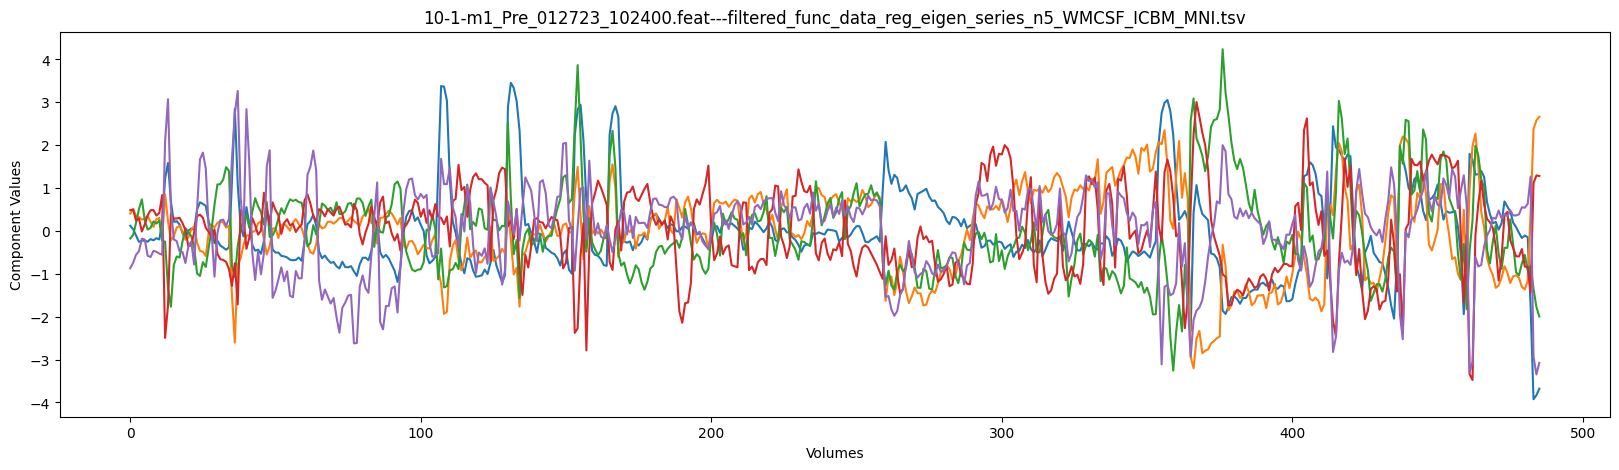

<Figure size 640x480 with 0 Axes>

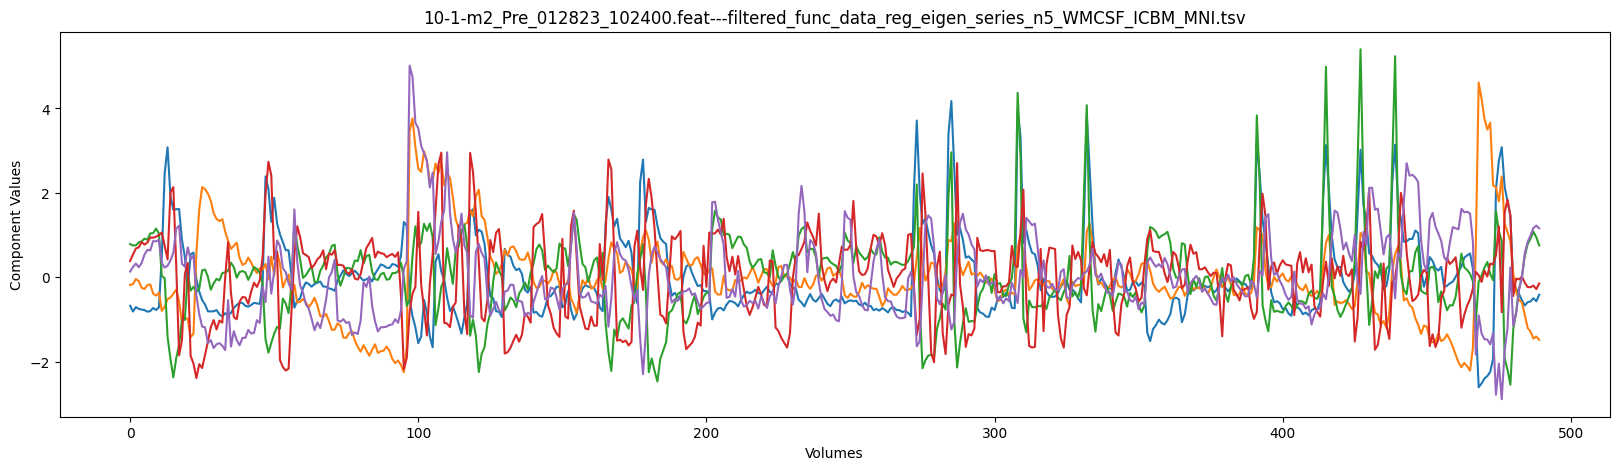

<Figure size 640x480 with 0 Axes>

In [52]:
# plot the combined components of WM and CSF with the corresponding title
for i in range(len(eigen_series)):
    plt.figure(figsize=(20, 5))
    plt.plot(np.loadtxt(eigen_series[i]))
    plt.title(os.path.basename(feat_folders[i]) + '---' + os.path.basename(eigen_series[i]))
    plt.xlabel('Volumes')
    plt.ylabel('Component Values')
    # plt.legend()
   
    plt.show()
    # save the plot as a png file in the path NLAcerebropath
    plt.savefig(eigen_series[i].replace('.tsv', '.png'))

## Concatenate Previous Design (3 Timing Files and derivatives, 6 Motion Parameters) TSVs,  eigen_series_n*_WMCSF_ICBM_MNI.tsv and motion outlier files

In [5]:
len(eigen_series)

287

TRIAL

In [9]:
matrix_path = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/12-1-m1_Pre_040323_102400.feat/design.mat'
df_init = get_design_from_fslmat(matrix_path, column_names=None)   # gets the design matrix from the .mat file as a dataframe
#print number of columns in the initial design matrix
print('Number of columns in the initial design matrix: ' + str(df_init.shape[1]) + ' for ' + matrix_path)
# drop first six columns of the design matrix which are the task timing and derivative for RorK, FGT and SHK; rerunning FEAT sh script will regenerate these columns
df_init = df_init.drop(df_init.columns[[0, 1, 2, 3, 4, 5]], axis=1) 

# the new dataframe has only 6 columns:6 Motion Parameters; avoiding a reconcatenation of the motion.par files for the design matrix
if df_init.shape[1] != 6:
    print('ERROR: Number of columns in the initial Motion Parameter design is not 6 for ' + 'matrix_path') 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (732,) + inhomogeneous part.

In [20]:
# get all design.mat files as dataframes and concatenate the eigen_series.tsv files as new columns

# for i in range(len(feat_folders)):
# for i in range(2): # trial loop 

# loop through a set of folders in 287 MEM feat_folders
for i in range(50, 288): # loop through 288 MEM feat_folders i.e. 0-287
    
    matrix_path = feat_folders[i] + '/design.mat'
    df_init = get_design_from_fslmat(matrix_path, column_names=None)   # gets the design matrix from the .mat file as a dataframe

    #print number of columns in the initial design matrix
    print(str(i) + ': Number of columns in the initial design matrix: ' + str(df_init.shape[1]) + ' for ' + matrix_path)
    # drop first six columns of the design matrix which are the task timing and derivative for RorK, FGT and SHK; rerunning FEAT sh script will regenerate these columns
    df_init = df_init.drop(df_init.columns[[0, 1, 2, 3, 4, 5]], axis=1) 

    # the new dataframe has only 6 columns:6 Motion Parameters plus custom motion outliers (total not < 6); avoiding a reconcatenation of the motion.par files for the design matrix
    if df_init.shape[1] < 6:
        print('ERROR: Number of columns in the initial Motion Parameter design is not less than 6 for ' + 'matrix_path') 

    # read the combined eigen_series.tsv file
    df_CmCr_n5 = pd.read_csv(eigen_series[i], header=None, sep='  ', engine='python')

    if df_CmCr_n5.shape[1] != 5:
        print('ERROR: Number of columns in the eigen series is not 5 for ' + eigen_series[i])

    #concate the motion parameters and eigen_series_n5 files as columns in a new dataframe
    df_combined_design = pd.concat([df_init, df_CmCr_n5], axis=1)

    # drop any NaN columns in the dataframe
    # df_design_n5 = df_design_n5.dropna(axis=1)

    # check if the number of rows in the dataframe; i.e.,  volumes in the scan
    # nvols = fslnvols(func_files[i])
    # if df_design_n5.shape[0] != nvols: #nvol
    #     print('ERROR: Number of rows in the dataframe is not 225 for ' + eigen_series[i])

    # check if the number of columns in the dataframe  i.e. eigen_series_n5 (6 mp + custom confounds from fdrms+ 5 CompCor)
    # if df_design_n5.shape[1] != 11:
    #     print('ERROR: Number of columns in the dataframe is not 11 for ' + eigen_series_n5[i])   
        
    # save the concatenated files as a txt file for EVs to FSL FEAT
    combined_design = eigen_series[i].replace('_eigen_series_n5_WMCSF_ICBM_MNI.tsv', '_mp6_fdrms1pt5_CmCrn5.txt') # a new filename for n5
    df_combined_design.to_csv(combined_design, index=False, header=False, sep='\t') # save the file as a tab separated txt file
    # print the number of columns in the new design matrix
    print('Number of columns in the combined design matrix: ' + str(df_combined_design.shape[1]) + ' for ' + combined_design)
    print('Saved ' + combined_design)


50: Number of columns in the initial design matrix: 12 for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/13-1-m1_Pre_012823_102400.feat/design.mat
Number of columns in the combined design matrix: 11 for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/13-1-m1_Pre_012823_102400.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt
Saved /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/13-1-m1_Pre_012823_102400.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt
51: Number of columns in the initial design matrix: 12 for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/13-1-m2_Pre_020723_102400.feat/design.mat
Number of columns in the combined design matrix: 11 for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/13-1-m2_Pre_020723_102400.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt
Saved /Volumes/cerebro/Studies/MCA_FMRI/Pub

IndexError: list index out of range

Now the TSVs files are consolidated into a single dataframe for each subject which can be fed as a .txt file as for subject level stats with the modified GLM.

**NOTE**: MCA12 has dimension errors while concatenating - no data for troubleshooting - feat_folders/design.mat for entries 48 and 49.

In [57]:
MCA_featpath

'/Volumes/cerebro/Studies/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat'

In [21]:
# list all the combined_design files in the NLAcerebropath in ascending order
combined_design_files = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt') 
combined_design_files.sort()
combined_design_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt',
 '/Volumes/cereb

Run until here : April 22, 2024 (MEM Dataset - minus 12-1 mem1 and mem2)

# GLM Schematic Representation - template

In [ ]:
design_matrix = pd.read_csv('/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/NLA02/Pain_func1/NLA02_Pain1_Pre_01082024_192248.feat/filtered_func_data_reg_Stats_CmCr-n5_01192024_114200.feat/design.mat', delimiter='\t', engine='python')
design_matrix

In [ ]:
glm_header = ['PainStim', 'PainStim_der', 'Motion1', 'Motion2', 'Motion3', 'Motion4', 'Motion5', 'Motion6', 'MotionOutlier', 'WM-CSF1', 'WM-CSF2', 'WM-CSF3', 'WM-CSF4', 'WM-CSF5']

In [ ]:
# glm = get_design_from_fslmat('/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/NLA02/Pain_func1/NLA02_Pain1_Pre_01082024_192248.feat/filtered_func_data_reg_Stats_CmCr-n5_01192024_114200.feat/design.mat', column_names=None)
glm_24_2 = get_design_from_fslmat('/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/NLA24/Pain_func2/NLA24_Pain2_Pre_01082024_105037.feat/filtered_func_data_reg_Stats_CmCr-n5_01192024_114200.feat/design.mat', column_names=glm_header)
glm_24_2

,PainStim,PainStim_der,Motion1,Motion2,Motion3,Motion4,Motion5,Motion6,MotionOutlier,WM-CSF1,WM-CSF2,WM-CSF3,WM-CSF4,WM-CSF5
0,0.000432,0.001321,-0.006232,0.000286,0.002246,-0.158097,-0.262990,-0.571085,2.434295,-0.370568,-2.999925,0.922435,-2.482751,-0.000034
1,0.001945,0.001217,-0.005267,0.000656,0.001351,-0.100805,-0.129577,-0.263743,1.117013,0.148882,-1.224075,0.382823,-0.568414,-0.000034
2,0.003251,0.000965,-0.002222,-0.000165,0.000164,-0.017164,0.157188,0.117047,-0.507475,0.722705,0.470433,-0.150818,-0.176656,-0.000034
3,0.004261,0.000634,-0.001348,0.000639,-0.000215,-0.033146,-0.005240,0.024543,-0.390560,0.351657,0.515529,-0.319497,0.984169,-0.000034
4,0.004904,0.000235,-0.001072,0.000556,-0.000247,-0.032209,-0.026327,0.077040,-0.120443,0.339184,0.372240,-0.307136,0.749627,-0.000034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0.031672,0.004728,-0.001780,0.000071,-0.000065,-0.075909,-0.160180,0.035263,-0.107091,0.358248,-0.122663,0.028355,0.708232,-0.000034
221,0.036030,0.003605,0.000399,0.000429,-0.000639,-0.042378,-0.137904,0.038824,0.299066,0.078920,-0.047810,-0.098664,0.474307,-0.000034
222,0.039272,0.002497,0.001732,0.000517,-0.001101,0.011181,0.060865,0.145779,-0.156844,0.017973,0.136252,-0.177790,-0.149912,-0.000034
223,0.041413,0.001403,0.001671,0.000998,-0.001239,0.016913,0.075061,0.144708,-0.331277,0.084387,0.497855,-0.215088,0.208701,-0.000034


<Axes: label='conditions', ylabel='scan number'>

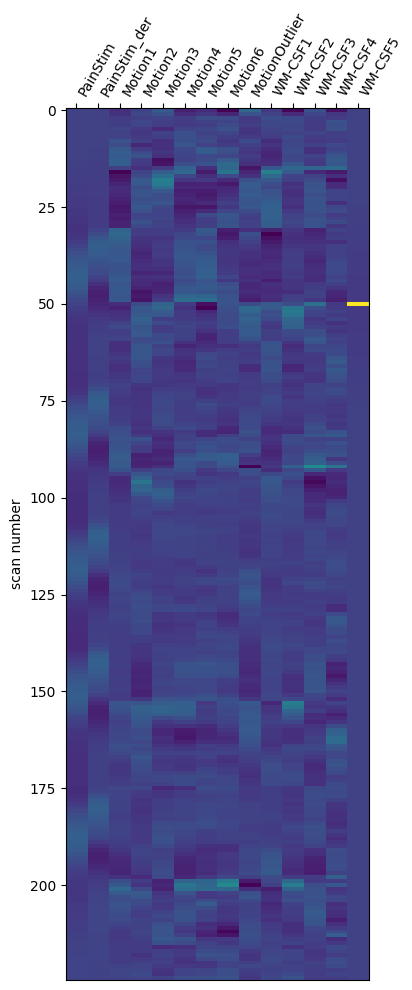

In [ ]:
plot_design_matrix(glm_24_2)

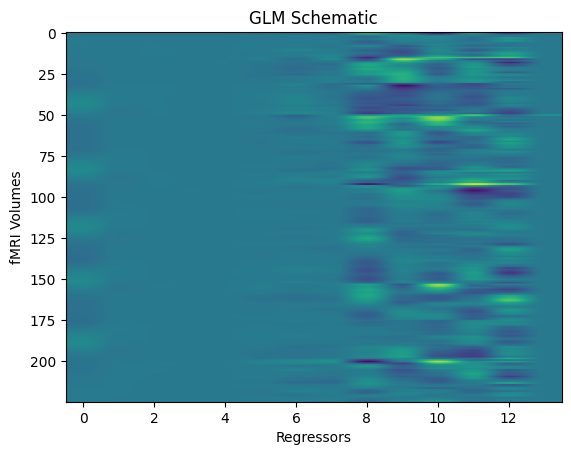

In [ ]:
plot_design_matrix(glm_24_2)

<Axes: label='conditions', ylabel='scan number'>

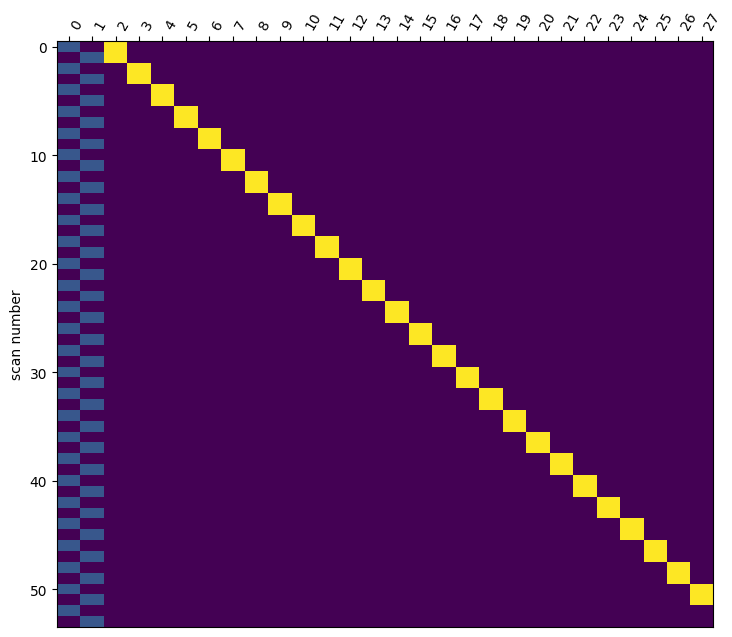

In [ ]:
#plot gp_stats model
gp_stats = '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/Group_Analysis/Gp_Ana_n27_z2-p05_ME12_fdrms1pt5_CmCr-n5_02072024_112000.gfeat/cope1.feat/design.mat'
gp_stats = get_design_from_fslmat(gp_stats, column_names=None)
plot_design_matrix(gp_stats)


In [ ]:
for i in range(len(combined_design_files)):
    mp_cmcr_n5 = pd.read_csv(combined_design_files[i], header=None, delimiter='\t', engine='python')
    plot_design_matrix(mp_cmcr_n5)

# MEM Group Analysis - trial runs/ template

First Level stats are run again for the feat_folders processed in the above steps with the new consolidated confounds for the GLM design using **MCA_MEM_firstlevelSTATSONLY_FEAT_checks.sh**

New copies of reg_standard folders from prior FEAT runs are saved in Stats.feat folders to avoid 'missing reg setup' error in higher level stats run. See Mac notes on Jan 24, 2024 for all the points and workaround options

## MEM - Second Level Intermediate Analyses

Make sure the older feat directories that are excluded from the current second level intermediate analysis are moved to /older_first_level/ folder. This will ensure that only the up-to-date edits of the motion outlier thresholds, CompCor computation, combined GLM design are contained in the /First_Level_Subj_Analyses/

In [ ]:
First_Level = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/'

In [ ]:
# create a dictionary for each subject
feat_dirs_dict = {}

# get all feat directories from the First_Level directory for a range of subjects from 7 to 116
for sub in range(7, 117):
    feat_dirs = glob.glob(First_Level + '{:d}-*.feat'.format(sub) + '/' + '{:d}-*_Stats.feat'.format(sub))
    # print the number of feat directories
    print(len(feat_dirs))

    
    # save the feat directories to a dictionary with the subject number as the key
    feat_dirs_dict[sub] = feat_dirs

    # print the feat directories as a dictionary
    print(feat_dirs_dict)

    # save the feat directories to a text file with the subject number if the number of feat directories is greater than or equal to 4
    # if len(feat_dirs) >= 4:
    #     with open(First_Level + '{:d}_feat_dirs.txt'.format(sub), 'w') as f:
    #         for feat_dir in feat_dirs:
    #             f.write(feat_dir + '\n')
        

    # # save the feat directories to a json file with the subject number
    # with open(First_Level + '{:d}_feat_dirs.json'.format(sub), 'w') as f:
    #     json.dump(feat_dirs, f)
    # print the path of the feat directories as a list
    print(feat_dirs)
    


0
{7: []}
[]
0
{7: [], 8: []}
[]
0
{7: [], 8: [], 9: []}
[]
2
{7: [], 8: [], 9: [], 10: ['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/10-1-m1_Stats.feat', '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/10-1-m2_Stats.feat']}
['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/10-1-m1_Stats.feat', '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/10-1-m2_Stats.feat']
0
{7: [], 8: [], 9: [], 10: ['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/10-1-m1_Stats.feat', '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/10-1-m2_Stats.feat'], 11: []}
[]
0
{7: [], 8: [], 9: [], 10: ['/Volumes/cerebro/Studies/MCA_FMRI/Public

In [ ]:
# show the contents of the dictionary for subject 7 as separate lines
for i, j in feat_dirs_dict.items():
    print(i,j)


7 []
8 []
9 []
10 ['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/10-1-m1_Stats.feat', '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/10-1-m2_Stats.feat']
11 []
12 []
13 []
14 []
15 []
16 []
17 []
18 []
19 []
20 []
21 []
22 []
23 []
24 []
25 []
26 []
27 []
28 []
29 []
30 []
31 []
32 []
33 []
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 []
47 []
48 []
49 []
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 []
59 []
60 []
61 []
62 []
63 []
64 []
65 []
66 []
67 []
68 []
69 []
70 []
71 []
72 []
73 []
74 []
75 []
76 []
77 []
78 []
79 []
80 []
81 []
82 []
83 []
84 []
85 []
86 []
87 []
88 []
89 []
90 []
91 []
92 []
93 []
94 []
95 []
96 []
97 []
98 []
99 []
100 []
101 []
102 []
103 []
104 []
105 []
106 []
107 []
108 []
109 []
110 []
111 []
112 []
113 []
114 []
115 []
116 []


In [ ]:
# sort each content of the dictionary chronologically
for i, j in feat_dirs_dict.items():
    j.sort()
    print(i,j)

7 []
8 []
9 []
10 ['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/10-1-m1_Stats.feat', '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/10-1-m2_Stats.feat']
11 []
12 []
13 []
14 []
15 []
16 []
17 []
18 []
19 []
20 []
21 []
22 []
23 []
24 []
25 []
26 []
27 []
28 []
29 []
30 []
31 []
32 []
33 []
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 []
47 []
48 []
49 []
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 []
59 []
60 []
61 []
62 []
63 []
64 []
65 []
66 []
67 []
68 []
69 []
70 []
71 []
72 []
73 []
74 []
75 []
76 []
77 []
78 []
79 []
80 []
81 []
82 []
83 []
84 []
85 []
86 []
87 []
88 []
89 []
90 []
91 []
92 []
93 []
94 []
95 []
96 []
97 []
98 []
99 []
100 []
101 []
102 []
103 []
104 []
105 []
106 []
107 []
108 []
109 []
110 []
111 []
112 []
113 []
114 []
115 []
116 []


In [ ]:
# show the contents of the dictionary for subject 7 as a pandas dataframe with the subject number as the index
df_feat_dirs = pd.DataFrame.from_dict(feat_dirs_dict, orient='index')
df_feat_dirs

,0,1,2,3
7,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,None,None
8,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,None,None
9,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...
10,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...
11,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,None,None
...,...,...,...,...
112,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...
113,None,None,None,None
114,None,None,None,None
115,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,None,None


In [ ]:
# show rows with 4 or more feat directories
df_2lvlinter = df_feat_dirs[df_feat_dirs.apply(lambda x: x.count(), axis=1) >= 4]
df_2lvlinter


,0,1,2,3
9,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...
10,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...
13,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...
18,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...
20,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...
24,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...
25,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...
26,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...
28,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...
29,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...,/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/...


## MEM - Third Level Analyses from 2nd level cope directories

In [ ]:
Second_Level = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses'

In [ ]:
# get all directories with the feat directories in Second_Level 
feat_2dirs = glob.glob(Second_Level + '/*.gfeat')
feat_2dirs

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses/Gp_2lvl_MC112_FE_03262024.gfeat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses/Gp_2lvl_MCA100_FE_04022024+.gfeat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses/Gp_2lvl_MCA103_FE_111423.gfeat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses/Gp_2lvl_MCA104_FE_03262024.gfeat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses/Gp_2lvl_MCA107_FE_03262024.gfeat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses/Gp_2lvl_MCA10_FE_032223+.gfeat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses/Gp_2lvl_MCA110_FE_03262024.gfeat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses/Gp_2lvl_MCA111_FE_03272024.gfea

In [ ]:
# get labels for the feat directories in Second_Level from the feat_2dirs list from _MCA_FE 
feat_2labels = [os.path.basename(feat_2dir) for feat_2dir in feat_2dirs]
feat_2labels

['Gp_2lvl_MC112_FE_03262024.gfeat',
 'Gp_2lvl_MCA100_FE_04022024+.gfeat',
 'Gp_2lvl_MCA103_FE_111423.gfeat',
 'Gp_2lvl_MCA104_FE_03262024.gfeat',
 'Gp_2lvl_MCA107_FE_03262024.gfeat',
 'Gp_2lvl_MCA10_FE_032223+.gfeat',
 'Gp_2lvl_MCA110_FE_03262024.gfeat',
 'Gp_2lvl_MCA111_FE_03272024.gfeat',
 'Gp_2lvl_MCA116_FE_03262024.gfeat',
 'Gp_2lvl_MCA13_FE_033123+.gfeat',
 'Gp_2lvl_MCA18_FE_040423.gfeat',
 'Gp_2lvl_MCA20_FE_033123+.gfeat',
 'Gp_2lvl_MCA24_FE_040323.gfeat',
 'Gp_2lvl_MCA25_FE_031523.gfeat',
 'Gp_2lvl_MCA26_FE_031523.gfeat',
 'Gp_2lvl_MCA28_FE_031523.gfeat',
 'Gp_2lvl_MCA29_FE_033123.gfeat',
 'Gp_2lvl_MCA30_FE_031523.gfeat',
 'Gp_2lvl_MCA31_FE_033123.gfeat',
 'Gp_2lvl_MCA33_FE_033123.gfeat',
 'Gp_2lvl_MCA40_FE_040323.gfeat',
 'Gp_2lvl_MCA41_FE_031523+.gfeat',
 'Gp_2lvl_MCA45_FE_031523.gfeat',
 'Gp_2lvl_MCA47_FE_031523.gfeat',
 'Gp_2lvl_MCA49_FE_031623.gfeat',
 'Gp_2lvl_MCA52_FE_033123.gfeat',
 'Gp_2lvl_MCA56_FE_032223+.gfeat',
 'Gp_2lvl_MCA57_FE_032123.gfeat',
 'Gp_2lvl_MCA58_FE_03

In [ ]:
# remove first three characters from the feat_2labels list
feat_2labels = ['12',
 '100',
 '103',
 '104',
 '107',
 '10',
 '110',
 '111',
 '116',
 '13',
 '18',
 '20',
 '24',
 '25',
 '26',
 '28',
 '29',
 '30',
 '31',
 '33',
 '40',
 '41',
 '45',
 '47',
 '49',
 '52',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '65',
 '66',
 '67',
 '68',
 '70',
 '72',
 '73',
 '74',
 '75',
 '76',
 '81',
 '83',
 '86',
 '90',
 '92',
 '94',
 '98',
 '9']


In [ ]:
feat_2labels.sort()
feat_2labels

['10',
 '100',
 '103',
 '104',
 '107',
 '110',
 '111',
 '116',
 '12',
 '13',
 '18',
 '20',
 '24',
 '25',
 '26',
 '28',
 '29',
 '30',
 '31',
 '33',
 '40',
 '41',
 '45',
 '47',
 '49',
 '52',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '65',
 '66',
 '67',
 '68',
 '70',
 '72',
 '73',
 '74',
 '75',
 '76',
 '81',
 '83',
 '86',
 '9',
 '90',
 '92',
 '94',
 '98']

feat_2labels are to be sorted for categorizing into saline vs drug groups for third level analysis.(info from MCA - Data Status April 11,2024). This will also have info for the unpaired sessions.